# ___House Price Prediction___

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [186]:
data = pd.read_csv("Housing.csv")
print("Dataset Shape:", data.shape)
data.head()

Dataset Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [188]:
data.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [189]:
data.duplicated().sum()

0

<Axes: >

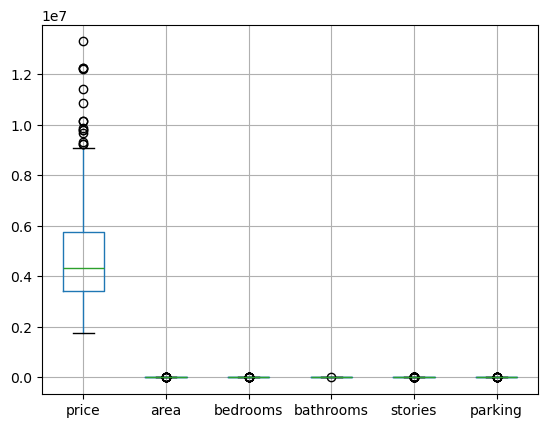

In [190]:
data.boxplot()

In [191]:
# removing outliers for price

Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]


<Axes: ylabel='price'>

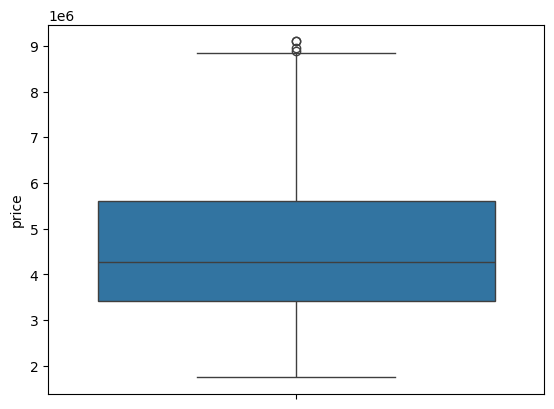

In [192]:
sns.boxplot(data['price'])

In [193]:
# removing outliers for Area

Q1 = data['area'].quantile(0.25)
Q3 = data['area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['area'] >= lower_bound) & (data['area'] <= upper_bound)]


<Axes: ylabel='price'>

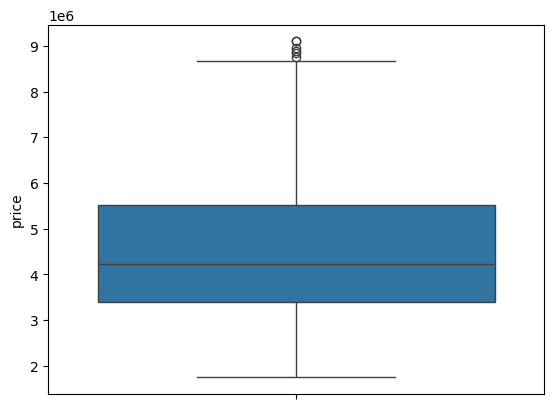

In [194]:
sns.boxplot(data['price'])

___Data Preprocessing___

In [195]:
data_encoded = data.copy()

In [196]:
# Binary encoding
binary_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
for col in binary_cols:
    data_encoded[col] = data_encoded[col].map({'yes':1, 'no':0})

In [197]:
# One-hot encoding for furnishingstatus
data_encoded = pd.get_dummies(data_encoded, columns=['furnishingstatus'], drop_first=True)

data_encoded.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
15,9100000,6000,4,1,2,1,0,1,0,0,2,0,True,False
16,9100000,6600,4,2,2,1,1,1,0,1,1,1,False,True
17,8960000,8500,3,2,4,1,0,0,0,1,2,0,False,False
18,8890000,4600,3,2,2,1,1,0,0,1,2,0,False,False
19,8855000,6420,3,2,2,1,0,0,0,1,1,1,True,False


In [198]:
# Features and target
X = data_encoded.drop("price", axis=1)
y = data_encoded["price"]

In [199]:
# Normalize features (for gradient descent stability)
X = (X - X.mean()) / X.std()

In [200]:
# Add bias term (column of ones)
X.insert(0, "bias", 1)

X.head()

,bias,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
15,1,0.623824,1.445983,-0.561109,0.236972,0.417925,-0.464814,1.372813,-0.210615,-0.665789,1.596231,-0.525365,1.184033,-0.714637
16,1,0.961060,1.445983,1.587730,0.236972,0.417925,2.147238,1.372813,-0.210615,1.499072,0.410525,1.899757,-0.842937,1.396605
17,1,2.028972,0.079304,1.587730,2.548563,0.417925,-0.464814,-0.727022,-0.210615,1.499072,1.596231,-0.525365,-0.842937,-0.714637
18,1,-0.163058,0.079304,1.587730,0.236972,0.417925,2.147238,-0.727022,-0.210615,1.499072,1.596231,-0.525365,-0.842937,-0.714637
19,1,0.859889,0.079304,1.587730,0.236972,0.417925,-0.464814,-0.727022,-0.210615,1.499072,0.410525,1.899757,1.184033,-0.714637


___Linear Regression (Gradient Descent)___

In [201]:
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum((predictions - y)**2)
    return cost

In [202]:
def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = []
    
    for _ in range(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        theta -= (learning_rate/m) * (X.T.dot(errors))
        cost_history.append(compute_cost(X, y, theta))
    return theta, cost_history

In [203]:
# Convert to numpy
X_np = X.values
y_np = y.values.reshape(-1,1)

# Initialize theta (weights)
theta = np.zeros((X_np.shape[1],1))

In [204]:
# Run gradient descent
theta_final, cost_history = gradient_descent(X_np, y_np, theta, learning_rate=0.01, iterations=500)

print("Final Theta (weights):\n", theta_final[:5])  # showing first few
print("Final Cost:", cost_history[-1])

Final Theta (weights):
 [[4538853.48766174]
 [ 431056.37424188]
 [  71252.42656245]
 [ 359491.70757131]
 [ 383113.82939763]]
Final Cost: 425963195547.8457


____Plot Cost Convergence____

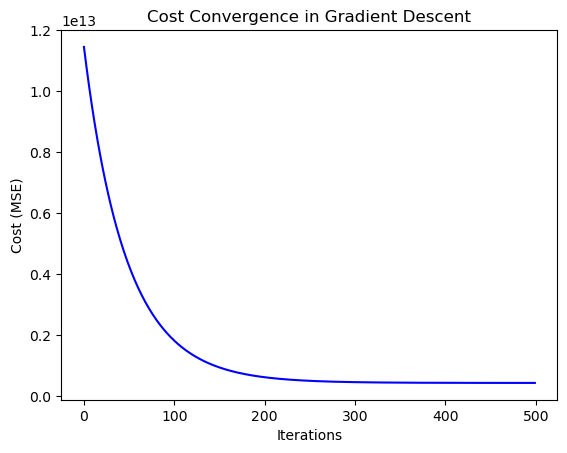

In [206]:
plt.plot(range(len(cost_history)), cost_history, color='blue')
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")
plt.title("Cost Convergence in Gradient Descent")
plt.show()

___Comparison with Sklearn___

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.drop("bias", axis=1), y, test_size=0.2, random_state=42)

# Sklearn Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)

In [208]:
# Evaluation
print("Sklearn MSE:", mean_squared_error(y_test, y_pred))
print("Sklearn R2 Score:", r2_score(y_test, y_pred))

Sklearn MSE: 954173744480.8947
Sklearn R2 Score: 0.674767344781106
